In [211]:
import glob

import gseapy as gp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from biomart import BiomartServer
from scripts import aesthetics
from sklearn import decomposition, preprocessing

from scripts import helper

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 1000)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Neuroblastoma Preprocess RNA

In this notebook, we'll process the RNA for the neuroblastoma and take a look at some QC metrics.

We have two datasets for this--data from Gabriella Miller Kids First (GMKF) as well as (later) St. Jude's data. This notebook will process both.

# Load our data - GMKF

In [212]:
# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

In [213]:
# list of genes that are annotated - drop ensembl IDs
gene_ref = pd.read_csv(
    "ref/gencode_hg38_protein_coding_genes_for_annotation_7_31_23.txt"
)
gene_ref = gene_ref[~gene_ref["value"].str.startswith("ENSG00")]
gene_ref = gene_ref["value"].tolist()

Load metadata and SVs

In [214]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

## Read in our RNA data

Load our TPMs. We'll briefly take a look at the manifest file first.

In [215]:
manifest = pd.read_csv(
    "data/CWAS data for Jett/GMKF_Neuroblastoma_Germline_Structural_Variant_Analysis_RSEM_expression_files/GMKF_neuroblastoma_transcriptomic_data_manifest_rsem_gene_files_2_22_22.txt",
    sep="\t",
)
manifest = manifest.dropna(subset=manifest.columns, how="all")
manifest.head(2)

,id,name,file_name_simplified,size,project,ethnicity,gender,race,vital_status,sample_id,sample_type,platform,age_at_diagnosis,tumor_location,aliquot_id,library_id,histology,composition,reference_genome,species,case_id,data_type,investigation,experimental_strategy
0,62140522c087b02cb6535584,4452cf2b-df37-439b-92d0-7e3853c50eee.rsem.gene...,4452cf2b-df37-439b-92d0-7e3853c50eee,2503209.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Female,Reported Unknown,Alive,BS_5W25GMQ1,Tumor,Illumina,1295.0,Reported Unknown,575765.0,GMKF-30-PATMDE03-01B-99R,"Ganglioneuroblastoma, intermixed",Solid Tissue,GRCh38,Homo sapiens,PT_4A1B95TK,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq
1,62140522c087b02cb6535578,7e31540e-112f-439a-9562-ad760bb6d5c5.rsem.gene...,7e31540e-112f-439a-9562-ad760bb6d5c5,2488632.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Male,White,Alive,BS_5Y7PNW71,Tumor,Illumina,1712.0,Reported Unknown,575872.0,GMKF-30-PAVKZC03-01A-01R,"Ganglioneuroblastoma, nodular",Solid Tissue,GRCh38,Homo sapiens,PT_GSWXPFPQ,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq


In [216]:
manifest.shape

(209, 24)

Not very useful at all, but it does give us a way to map file names to sample names.

In [217]:
file_to_sample = dict(zip(manifest["name"], manifest["case_id"]))

In [325]:
merged_tpms = []
merged_counts = []
for file in glob.glob(
    "data/CWAS data for Jett/GMKF_Neuroblastoma_Germline_Structural_Variant_Analysis_RSEM_expression_files/*.rsem.genes.tsv"
):
    file_name = file.split("/")[-1][:-3] + "results.gz"

    sample = file_to_sample[file_name]

    data = pd.read_csv(file, sep="\t")
    data["sample"] = sample
    merged_tpms.append(data[["sample", "gene_id", "TPM"]])
    merged_counts.append(data[["sample", "gene_id", "expected_count"]])

merged_tpms = pd.concat(merged_tpms)
merged_tpms = merged_tpms.pivot(
    index="gene_id", columns="sample", values="TPM"
).reset_index()

merged_counts = pd.concat(merged_counts)
merged_counts = merged_counts.pivot(
    index="gene_id", columns="sample", values="expected_count"
).reset_index()

In [326]:
for d in [merged_tpms, merged_counts]:
    d.insert(1, "ENSEMBL_ID", d["gene_id"].apply(lambda x: x.split(".")[0]))
    d.insert(2, "gene_symbol", d["gene_id"].apply(lambda x: x.split("_")[-1]))

In [327]:
merged_tpms.to_csv("data/merged_neuroblastoma_tpms_gmkf.tsv", sep="\t", index=False)
merged_counts.to_csv("data/merged_neuroblastoma_counts_gmf.tsv", sep="\t", index=False)

In [337]:
merged_tpms_protein_coding = merged_tpms[merged_tpms["gene_symbol"].isin(gene_ref)]

## Fetch the GMKF reference

Because we'll need it later, GMKF used Gencode v39 in their RSEM run

In [151]:
gmkf_gtf = helper.read_gtf("https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_31/gencode.v31.annotation.gtf.gz")
gmkf_gtf = helper.clean_and_subset_gtf(gmkf_gtf, gene_ref)

## Normalize counts and TPMs

We renormalize counts to normalized counts

In [338]:
gmkf_counts_norm = merged_counts.copy()

row_sums = gmkf_counts_norm.iloc[:, 3:].sum(axis=1).values.reshape(-1, 1)
gmkf_counts_norm.iloc[:, 3:] = (gmkf_counts_norm.iloc[:, 3:] / row_sums) * 1e6

We have to renormalize TPMs:

In [339]:
merged_tpms_protein_coding_renorm = merged_tpms_protein_coding.iloc[:, 3:].copy()

# renormalize both
merged_tpms_protein_coding_renorm = (merged_tpms_protein_coding_renorm / merged_tpms_protein_coding_renorm.sum()) * 1e6

merged_tpms_protein_coding.iloc[:, 3:] = merged_tpms_protein_coding_renorm

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


## Examine our TPMs

Our first step, naturally, is to examine our TPMs. There are a few questions we need to answer about this dataset.

First, how many samples are present?

## Sample characteristics

In [225]:
samples = list(merged_tpms.columns[3:])
len(samples)

209

And how many of these samples do we actually have SVs for?

In [226]:
len(set(metadata["entity:sample_id"]) & set(samples))

158

Only 158... I assume that these samples were dropped for QC reasons.

In [227]:
metadata[metadata["entity:sample_id"].isin(samples)].groupby(
    ["neuroblastoma_case"]
).size()

neuroblastoma_case
False    69
True     89
dtype: int64

So a large number of these samples were actually dropped from the case control analysis, presumably for sample specific reasons. Unfortunate.

In [228]:
included_samples = metadata[
    (metadata["entity:sample_id"].isin(samples))
    & (metadata["neuroblastoma_case"] == True)
]["entity:sample_id"].tolist()
len(included_samples)

89

We'll keep them in the dataset for now, just because _theoretically_ they could be useful for increased power in the setting of singleton SVs. We believe that singleton SVs are where our signal is, so we might actually be able to use poorly genotyped samples in that setting.

If we want to drop them, we can do so later.

In [229]:
# merged_tpms = merged_tpms[list(merged_tpms.columns[:3]) + included_samples]
# merged_counts = merged_counts[list(merged_counts.columns[:3]) + included_samples]
# merged_tpms_protein_coding = merged_tpms_protein_coding[
#     list(merged_tpms_protein_coding.columns[:3]) + included_samples
# ]

## TPM quality

It's pretty damn hard to assess the quality of RNA sequencing post-hoc, but we'll give it our best shot. We have 89 samples. I'd like to know some underlying features of this data.

The first thing we can do is just snoRNAs, which can be high in bad data.

## snoRNAs

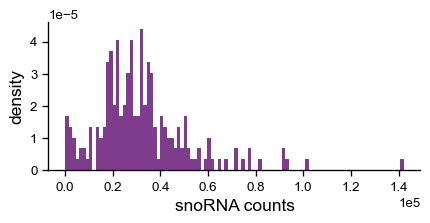

In [230]:
sno_rsem = merged_counts[merged_counts["gene_symbol"].str.contains("SNO")].iloc[:, 3:]

# filter down to any sno "genes" that have nonzero reads in any samples
fig, ax = plt.subplots(1, figsize=(5, 2))
plt.hist(sno_rsem.loc[(sno_rsem != 0).any(axis=1)].sum(axis=0), bins=100, density=True)
ax.set_xlabel("snoRNA counts")
ax.set_ylabel("density")
sns.despine(ax=ax)
fig.savefig("images/cwas/tpms-snorna-counts.png", bbox_inches="tight")

Some of those values are definitely a little higher than I'd like, but it is what it is. I don't know enough to create some filter.

## PCA plot

In [231]:
tpm_dict = {
    "log_1p": np.log1p(merged_tpms.iloc[:, 3:]),
    "log_1p_protein": np.log1p(merged_tpms_protein_coding.iloc[:, 3:]),
}

In [232]:
# normalize for PCA
pca_dict = {}
pca_models = {}
for label, matrix in tpm_dict.items():
    norm_matrix = preprocessing.StandardScaler().fit_transform(matrix.T)
    pca = decomposition.PCA(
        n_components=min(norm_matrix.shape[0] - 1, norm_matrix.shape[1]), random_state=0
    )

    # store the model
    pca_models[label] = pca

    # transform the data, then store the PC results
    pca_transformed_data = pca.fit_transform(norm_matrix)

    pca_tpm_df = pd.DataFrame(pca_transformed_data)
    pca_tpm_df.columns = ["PC" + str(i) for i in range(1, len(pca_tpm_df.columns) + 1)]
    pca_tpm_df.index = merged_tpms.columns[3:]

    pca_dict[label] = pca_tpm_df

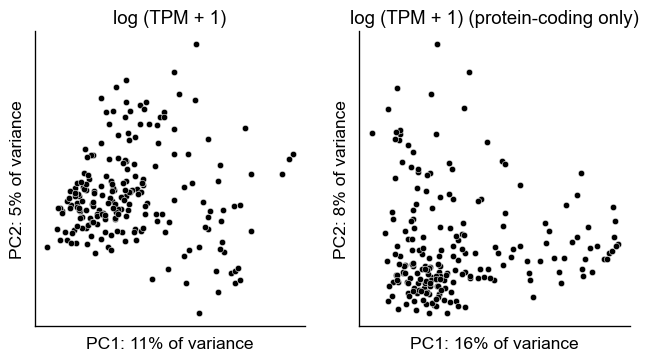

In [233]:
tpm_fig, tpm_axes = plt.subplots(1, 2, figsize=(8, 4))
for i, label in enumerate(["log_1p", "log_1p_protein"]):

    data = pca_dict[label][["PC1", "PC2"]].copy()

    # plot data
    sns.scatterplot(x="PC1", y="PC2", data=data, ax=tpm_axes[i], color="black")

    tpm_axes[i].set_xticklabels([])
    tpm_axes[i].set_yticklabels([])
    tpm_axes[i].tick_params(axis="both", which="both", length=0)

    pca_results = pca_models[label]
    tpm_axes[i].set_xlabel(
        "PC1: {:.0f}% of variance".format(
            pca_results.explained_variance_ratio_[0] * 100
        )
    )
    tpm_axes[i].set_ylabel(
        "PC2: {:.0f}% of variance".format(
            pca_results.explained_variance_ratio_[1] * 100
        )
    )
    tpm_axes[i].set_title(
        ["log (TPM + 1)", "log (TPM + 1) (protein-coding only)", "log (TPM + 1) (hvg)"][
            i
        ]
    )

    sns.despine(bottom=False, left=False)

Obviously, this tells us nothing up front.

## House keeping genes

Another metric we can use is the count of house-keeping genes.

In [234]:
housekeeping = ["ACTB", "GAPDH", "TBP", "UBC", "RPS18"]
housekeeping_counts = (
    merged_counts[merged_counts["gene_symbol"].isin(housekeeping)]
    .set_index("gene_symbol")
    .iloc[:, 2:]
)
housekeeping_counts_norm = stats.zscore(housekeeping_counts, axis=1)

Let's plot these on a heatmap

In [235]:
housekeeping_counts_norm

sample,PT_02SNWVRF,PT_0XAWD5CE,PT_10KTTTPD,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1MWZEHCT,PT_1NDSW1JX,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_1YAJEAMJ,PT_21PJ8R0Z,PT_22BQQFYM,PT_26E4RFYV,PT_2AZNEYG9,PT_2DX56CE0,PT_2FB9C15K,PT_2G290D0G,PT_2HCWZNTR,PT_2JZNQGTR,PT_2M970JK9,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_2YBKT6RW,PT_3VNMNFT6,PT_3WF5J3PZ,PT_3YW2V4JK,PT_49FZV0HC,PT_4A1B95TK,PT_4FTZAAC4,PT_4W8PD8TR,PT_4WVGKQRX,PT_4Y3P2N1P,PT_53M7K3JE,PT_56ZM694R,PT_581CW7RN,PT_58J0PB4V,PT_5CPS8GNT,PT_5E269C8Z,PT_5FCYBT0S,PT_5MA1YQ49,PT_5W51TAZS,PT_64B8K70Y,PT_66Y5KGME,PT_69AGBVQ5,PT_69EVASRX,PT_6DHGCDRP,PT_6HZH56MX,PT_6M0TPG4X,PT_6R3RJ6MY,PT_6TM0T48Z,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_7XV9SBKQ,PT_81RSHW1D,PT_82D2FJV2,PT_86NG4W76,PT_89D6BFGP,PT_8BYCCC0V,PT_8DFBAQVQ,PT_8HFHWZH9,PT_8RQQWAQR,PT_92RR9C8D,PT_9A9Q2YB3,PT_9DD8F0VD,PT_9GRB7EF0,PT_9K8VF0Z0,PT_9KB3ESTZ,PT_9NMNEV0Y,PT_9QQ37AWW,PT_9RJY3GWC,PT_9X3MV3GW,PT_A4VM4H5N,PT_A77B7F2F,PT_AGYJR7PZ,PT_APMAKP20,PT_AQS8CCAB,PT_ASH4P45D,PT_ASJZTDRF,PT_ATQMV6B3,PT_B0YZ0H85,PT_B39849MF,PT_B9CP3H35,PT_B9X3H54Y,PT_BZCXTAH9,PT_BZZY1BM4,PT_C32MGZSB,PT_C3YC0C9Q,PT_C6429DZZ,PT_CCC65GCE,PT_CV0FE3Z3,PT_D4SZQV48,PT_D508JGWE,PT_D5BYDHZ9,PT_D9XF79J4,PT_DCBZYQAX,PT_DP679T4D,PT_DS5XN67S,PT_E3R0MRXN,PT_E6CZS2KF,PT_E7PFZT6E,PT_ECTDZ6QS,PT_EKP4F49T,PT_ESKA5P5B,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FW0K9SXK,PT_FZ3XEWEK,PT_G3Q35987,PT_GGJ9E0VV,PT_GQBEY0JD,PT_GSWXPFPQ,PT_GV2XJJTP,PT_H2Q0BW73,PT_H3GBG09Q,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HC1QFR28,PT_HQ23GQ23,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_HZQ6TWR9,PT_J3X9NQ5F,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K5709E5B,PT_K579G3KQ,PT_K59VNJ70,PT_KBT22K39,PT_KBVX8B37,PT_KH0H9EZS,PT_KRHMQFFP,PT_KWEJJM22,PT_KWRFGRER,PT_KX5R6KSM,PT_KXWQXAR4,PT_M4ETZ912,PT_M6QAJFS8,PT_M8RHAK5K,PT_MG3HP8D9,PT_MK375DCF,PT_NK39AFPG,PT_NYMKWAZT,PT_NZ3F3J67,PT_P111JVHP,PT_P2M0Q2KS,PT_P7V330C5,PT_P9QJMTF8,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QCMS0C3W,PT_QF2A2F08,PT_QH23VVKW,PT_QW5Q0G84,PT_QZFYXPJK,PT_R07QYFJ0,PT_R94DDN50,PT_RG7MMHFF,PT_RJPEMEQV,PT_RMH6RJ1P,PT_RS3TBZV5,PT_RSPKGFXS,PT_RVTVP55V,PT_S4EJKTME,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V1HR5C5P,PT_V3BXBVVV,PT_V65ESGCE,PT_VA8GM98Z,PT_VVVS471N,PT_W6AVZF18,PT_WG51EA8V,PT_WH6RANZQ,PT_WSQ011Z1,PT_WWQGABFP,PT_WWRAC6EH,PT_X8N7GE8X,PT_XDPN4357,PT_XKZYFJZV,PT_XNBJNRXJ,PT_XNDPC9TT,PT_XPGEBQKA,PT_XPTE7785,PT_YGW6KQHQ,PT_YHWENHB0,PT_YJ8KZG27,PT_YMDFCE4V,PT_YPK89ADE,PT_YS31MFW0,PT_YYGH8EMR,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZS5D8MVF,PT_ZT2NW6WA,PT_ZW22K0YF
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACTB,0.122331,-0.765518,0.327397,1.928226,-0.153623,-0.748021,1.191358,0.713033,1.156279,-0.675784,-0.736558,1.234719,0.324286,-0.578615,-0.419048,-0.202749,-1.738698,-0.519291,-1.629634,0.291364,0.197110,0.229384,2.732868,1.340938,-1.307591,-0.665794,-0.691276,-0.503405,-1.418483,-0.872605,0.869875,0.968843,-1.123332,-0.406113,2.314742,0.967317,-0.063082,-0.186298,-0.605089,-1.673864,0.392079,-0.667835,-0.546111,-0.319041,-0.401075,-0.220860,-0.247001,-0.109644,1.437829,0.274326,0.769605,-0.831419,-0.204828,3.439282,0.912320,0.156034,0.216931,-0.704652,1.101330,0.715006,-0.244259,-0.351008,0.964824,0.118909,-0.058539,-0.075745,1.307634,0.170241,-0.674170,0.449634,0.054308,-0.733071,-0.738264,-0.566577,-0.218210,-0.073524,-0.018616,-0.353294,-0.101474,-0.516993,2.070261,-0.545409,-0.420364,0.603188,0.323974,-0.085574,-1.054629,-0.762808,-0.149151,-1.211460,-0.162155,-1.036797,0.095135,-0.026245,-0.105297,0.256900,1.108611,-0.073601,-0.769086,0.429664,0.380156,2.437190,-0.139571,-0.322063,-0.382710,-0.025095,-1.291054,-0.896570,-0.121220,0.361053,0.675948,0.502522,0.317380,-0.104994,-0.238768,2.938825,-1.637976,2.573060,-0.503358,0.754198,0.627997,-1.052467,4.126692,0.409473,-0.121647,1.745979,-0.594830,-0.262512,-0.305508,-0.534117,-1.094631,-0

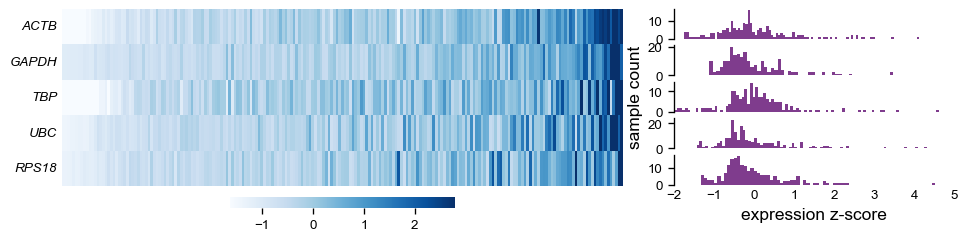

In [236]:
# define a rough order
sample_order = housekeeping_counts_norm.mean(axis=0).sort_values().index

# make the figure and gridspec
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(5, 2, width_ratios=[2, 1], wspace=0.12)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[:, 0])

sns.heatmap(
    housekeeping_counts_norm.loc[:, sample_order],
    cmap="Blues",
    robust=True,
    ax=heatmap_ax,
    cbar_kws={"orientation": "horizontal", "pad": 0.05, "shrink": 0.4},
)
heatmap_ax.set_yticklabels(housekeeping, rotation=0, ha="right", fontstyle="italic")
heatmap_ax.tick_params(which="both", length=0)
heatmap_ax.set_xticklabels([])
heatmap_ax.set_ylabel("")
heatmap_ax.set_xlabel("")

gene_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
    6, 1, gs[:, 1], height_ratios=[1] * 5 + [1.3]
)
for i, g in enumerate(housekeeping):
    ax = fig.add_subplot(gene_gs[i])
    ax.hist(housekeeping_counts_norm.loc[g, :], bins=100)
    sns.despine(ax=ax, bottom=True)
    ax.set_xlim([-2, 5])
    if i != 4:
        ax.get_xaxis().set_visible(False)

    else:
        ax.tick_params(axis="x", length=0)
        ax.set_xlabel("expression z-score")

    if i == 2:
        ax.set_ylabel("sample count")

fig.savefig("images/cwas/housekeeping-expression.png", bbox_inches="tight")

We can try arbitrarily removing a subset of samples if they exceed 2.5 stds of housekeeping expression in 3 housekeeping genes.

In [237]:
percentiles = np.percentile(housekeeping_counts_norm, [95], axis=1).reshape(-1, 1)
sample_filter = np.greater(housekeeping_counts_norm, percentiles)
removed_samples = sample_filter.loc[:, sample_filter.sum(axis=0) >= 3]
removed_samples

sample,PT_2QB9MP9J,PT_6WE8JADD,PT_DP679T4D,PT_GGJ9E0VV,PT_HB9JT4G5,PT_P111JVHP,PT_YMDFCE4V
gene_symbol,,,,,,,
ACTB,True,True,True,True,True,True,True
GAPDH,False,True,True,True,True,True,True
TBP,True,True,True,True,True,False,True
UBC,True,True,True,False,True,True,True
RPS18,False,False,True,True,True,False,False


In [238]:
removed_samples = removed_samples.columns

Out of curiosity, how does this look on a PCA plot?

In [239]:
housekeeping_mean = housekeeping_counts_norm.mean(axis=0)

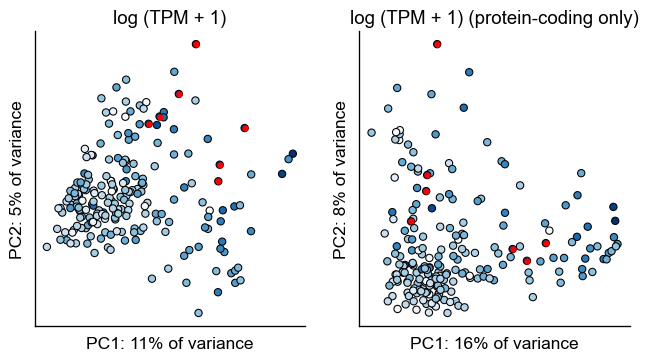

In [240]:
tpm_fig, tpm_axes = plt.subplots(1, 2, figsize=(8, 4))

norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=2)
for i, label in enumerate(["log_1p", "log_1p_protein"]):

    data = pca_dict[label][["PC1", "PC2"]].copy()

    # add in housekeeping data
    data["housekeeping"] = housekeeping_mean.loc[data.index]

    # plot data
    points = tpm_axes[i].scatter(
        data["PC1"],
        data["PC2"],
        c=data["housekeeping"],
        cmap=plt.get_cmap("Blues"),
        norm=norm,
        edgecolor="black",
        s=30,
    )

    removed = data.loc[removed_samples]
    points = tpm_axes[i].scatter(
        removed["PC1"], removed["PC2"], c="red", edgecolor=None, s=15
    )

    tpm_axes[i].set_xticklabels([])
    tpm_axes[i].set_yticklabels([])
    tpm_axes[i].tick_params(axis="both", which="both", length=0)

    pca_results = pca_models[label]
    tpm_axes[i].set_xlabel(
        "PC1: {:.0f}% of variance".format(
            pca_results.explained_variance_ratio_[0] * 100
        )
    )
    tpm_axes[i].set_ylabel(
        "PC2: {:.0f}% of variance".format(
            pca_results.explained_variance_ratio_[1] * 100
        )
    )
    tpm_axes[i].set_title(
        ["log (TPM + 1)", "log (TPM + 1) (protein-coding only)", "log (TPM + 1) (hvg)"][
            i
        ]
    )

    sns.despine(bottom=False, left=False)

tpm_fig.savefig("images/cwas/tpm-pca-matrix.png", bbox_inches="tight")

I mean... meh, right? Clearly these samples are slight outliers, but I see no reason to believe they're extremely abnormal. I don't see a frank need to remove them. So we keep all 89 samples.

## Adrenal signature

One important component of this analysis is that we have no idea of the underlying purity of these samples. This could be a pretty big problem, as eventually we'll be ranking these samples by expression. If a subset of samples have consistently low purity and these genes are relevant in an adrenal context, then we could get skewed results.

One way to check this is to devise an expression signature that is derived from adrenal-specific genes. This could (theoretically) help us control for these effects downstream. Maybe.

In [241]:
adrenal_genes = pd.read_csv("ref/adrenal-specific-genes.txt", sep="\t", comment="#")[
    "Gene Name"
].tolist()
print(adrenal_genes)

['CYP17A1', 'CHGB', 'CYP11B1', 'STAR', 'HSD3B2', 'AKR1B1', 'CYP21A2', 'NOV', 'FDX1', 'DBH', 'SOAT1', 'MGARP', 'TH', 'AS3MT', 'PNMT', 'VWA5B2', 'MCOLN3', 'ARHGAP36', 'CARTPT', 'CYP11B2', 'KCNK2', 'CHRNA3', 'MC2R', 'SLC18A1', 'MAP3K15', 'PHOX2A', 'RET', 'FAM19A4', 'AP000783.1', 'C18orf42', 'AC015660.1', 'PHOX2B', 'FAM43B', 'DRGX', 'UCP1']


In [242]:
merged_tpms_pc_gsea = merged_tpms_protein_coding.set_index("gene_symbol").iloc[:, 2:]
merged_tpms_pc_gsea.head(2)

sample,PT_02SNWVRF,PT_0XAWD5CE,PT_10KTTTPD,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1MWZEHCT,PT_1NDSW1JX,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_1YAJEAMJ,PT_21PJ8R0Z,PT_22BQQFYM,PT_26E4RFYV,PT_2AZNEYG9,PT_2DX56CE0,PT_2FB9C15K,PT_2G290D0G,PT_2HCWZNTR,PT_2JZNQGTR,PT_2M970JK9,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_2YBKT6RW,PT_3VNMNFT6,PT_3WF5J3PZ,PT_3YW2V4JK,PT_49FZV0HC,PT_4A1B95TK,PT_4FTZAAC4,PT_4W8PD8TR,PT_4WVGKQRX,PT_4Y3P2N1P,PT_53M7K3JE,PT_56ZM694R,PT_581CW7RN,PT_58J0PB4V,PT_5CPS8GNT,PT_5E269C8Z,PT_5FCYBT0S,PT_5MA1YQ49,PT_5W51TAZS,PT_64B8K70Y,PT_66Y5KGME,PT_69AGBVQ5,PT_69EVASRX,PT_6DHGCDRP,PT_6HZH56MX,PT_6M0TPG4X,PT_6R3RJ6MY,PT_6TM0T48Z,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_7XV9SBKQ,PT_81RSHW1D,PT_82D2FJV2,PT_86NG4W76,PT_89D6BFGP,PT_8BYCCC0V,PT_8DFBAQVQ,PT_8HFHWZH9,PT_8RQQWAQR,PT_92RR9C8D,PT_9A9Q2YB3,PT_9DD8F0VD,PT_9GRB7EF0,PT_9K8VF0Z0,PT_9KB3ESTZ,PT_9NMNEV0Y,PT_9QQ37AWW,PT_9RJY3GWC,PT_9X3MV3GW,PT_A4VM4H5N,PT_A77B7F2F,PT_AGYJR7PZ,PT_APMAKP20,PT_AQS8CCAB,PT_ASH4P45D,PT_ASJZTDRF,PT_ATQMV6B3,PT_B0YZ0H85,PT_B39849MF,PT_B9CP3H35,PT_B9X3H54Y,PT_BZCXTAH9,PT_BZZY1BM4,PT_C32MGZSB,PT_C3YC0C9Q,PT_C6429DZZ,PT_CCC65GCE,PT_CV0FE3Z3,PT_D4SZQV48,PT_D508JGWE,PT_D5BYDHZ9,PT_D9XF79J4,PT_DCBZYQAX,PT_DP679T4D,PT_DS5XN67S,PT_E3R0MRXN,PT_E6CZS2KF,PT_E7PFZT6E,PT_ECTDZ6QS,PT_EKP4F49T,PT_ESKA5P5B,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FW0K9SXK,PT_FZ3XEWEK,PT_G3Q35987,PT_GGJ9E0VV,PT_GQBEY0JD,PT_GSWXPFPQ,PT_GV2XJJTP,PT_H2Q0BW73,PT_H3GBG09Q,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HC1QFR28,PT_HQ23GQ23,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_HZQ6TWR9,PT_J3X9NQ5F,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K5709E5B,PT_K579G3KQ,PT_K59VNJ70,PT_KBT22K39,PT_KBVX8B37,PT_KH0H9EZS,PT_KRHMQFFP,PT_KWEJJM22,PT_KWRFGRER,PT_KX5R6KSM,PT_KXWQXAR4,PT_M4ETZ912,PT_M6QAJFS8,PT_M8RHAK5K,PT_MG3HP8D9,PT_MK375DCF,PT_NK39AFPG,PT_NYMKWAZT,PT_NZ3F3J67,PT_P111JVHP,PT_P2M0Q2KS,PT_P7V330C5,PT_P9QJMTF8,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QCMS0C3W,PT_QF2A2F08,PT_QH23VVKW,PT_QW5Q0G84,PT_QZFYXPJK,PT_R07QYFJ0,PT_R94DDN50,PT_RG7MMHFF,PT_RJPEMEQV,PT_RMH6RJ1P,PT_RS3TBZV5,PT_RSPKGFXS,PT_RVTVP55V,PT_S4EJKTME,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V1HR5C5P,PT_V3BXBVVV,PT_V65ESGCE,PT_VA8GM98Z,PT_VVVS471N,PT_W6AVZF18,PT_WG51EA8V,PT_WH6RANZQ,PT_WSQ011Z1,PT_WWQGABFP,PT_WWRAC6EH,PT_X8N7GE8X,PT_XDPN4357,PT_XKZYFJZV,PT_XNBJNRXJ,PT_XNDPC9TT,PT_XPGEBQKA,PT_XPTE7785,PT_YGW6KQHQ,PT_YHWENHB0,PT_YJ8KZG27,PT_YMDFCE4V,PT_YPK89ADE,PT_YS31MFW0,PT_YYGH8EMR,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZS5D8MVF,PT_ZT2NW6WA,PT_ZW22K0YF
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,14.112820,29.460532,20.125821,7.713228,17.499009,28.323379,16.110147,18.851378,4.428487,12.772935,12.659250,15.929882,9.398216,20.946133,23.163382,37.170394,0.0,12.690406,23.667845,10.454762,18.57029,17.100006,13.414656,12.970123,6.319128,15.516984,20.14064,26.665287,31.377756,24.300358,23.106157,23.682832,17.031288,12.920685,13.202834,19.709303,18.129452,10.071864,16.789573,12.750521,29.846743,15.621338,15.716859,23.543236,16.591863,18.016507,6.931721,4.493649,17.567391,23.587188,13.64809,54.034697,13.607965,8.279729,12.920682,38.114842,13.380333,22.667944,18.4932,48.168005,19.590408,24.013405,22.367573,25.567429,28.974155,19.894300,13.271557,54.258651,18.141597,26.423918,12.282623,51.296425,27.838695,36.378757,11.614514,29.232956,44.351878,12.026872,10.048485,8.647606,10.166259,8.910095,28.681710,10.045593,34.286429,22.349782,13.036772,31.024353,39.683585,22.433026,10.564336,3.663385,14.159791,18.434179,22.153671,18.296677,15.365117,34.437806,23.389802,10.434784,25.749811,17.598504,9.332272,20.232581,22.396928,22.590236,16.356743,14.191828,13.320587,37.169833,12.965782,16.529480,15.605915,42.913875,14.271066,16.001307,20.859304,22.906096,19.155749,75.773126,19.050599,20.510357,20.912948,8.084714,18.107396,17.382330,30.218067,10.890005,

In [243]:
ss = gp.ssgsea(
    data=merged_tpms_pc_gsea,
    gene_sets={"adrenal": adrenal_genes},
    outdir=None,
    sample_norm_method="rank",
    no_plot=True,
    min_size=4,
)

adrenal_signature = ss.res2d
adrenal_signature.columns = [
    "sample",
    "signature",
    "enrichment_score",
    "normalized_enrichment_score",
]

2024-02-11 21:43:35,790 [WARNING] Found duplicated gene names, values averaged by gene names!


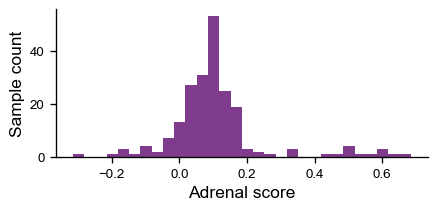

In [244]:
fig, ax = plt.subplots(1, figsize=(5, 2))
plt.hist(adrenal_signature["normalized_enrichment_score"], bins=30)
ax.set_xlabel("Adrenal score")
ax.set_ylabel("Sample count")
sns.despine()
fig.savefig("images/cwas/adrenal-specific-expression.png", bbox_inches="tight")

So there's definitely some variation there. This will be important to keep in mind.

## Process and export count data

For use in our analysis notebook, we'll export the normalized counts. We don't actually care about TPMs because we're doing rank-based analyses.

We first need to subset down to genes present in our gene reference.

In [245]:
gmkf_gtf.head(2)

,chromosome,source,feature,start,end,score,strand,phase,attributes,gene_id,gene_type
gene_name,,,,,,,,,,,
OR4F5,chr1,HAVANA,gene,65419,71585,.,+,.,"{'gene_id': 'ENSG00000186092.6', 'gene_type': ...",ENSG00000186092,protein_coding
OR4F29,chr1,HAVANA,gene,450703,451697,.,-,.,"{'gene_id': 'ENSG00000284733.1', 'gene_type': ...",ENSG00000284733,protein_coding


In [246]:
gmkf_counts_norm_export = gmkf_counts_norm[gmkf_counts_norm['ENSEMBL_ID'].isin(gmkf_gtf['gene_id'])].copy()

# drop genes that aren't expressed
gmkf_counts_norm_export = gmkf_counts_norm_export.dropna()

Next we drop samples that don't have any expression in our select samples

In [247]:
included_genes = gmkf_counts_norm_export['ENSEMBL_ID'].tolist()

merged_counts_protein_coding = (
    merged_counts[merged_counts["ENSEMBL_ID"].isin(included_genes)]
    .iloc[:, 1:]
    .drop(columns = ['gene_symbol'])
    .set_index("ENSEMBL_ID")
)

included_samples = metadata[
    (metadata["entity:sample_id"].isin(samples))
    & (metadata["neuroblastoma_case"] == True)
]["entity:sample_id"].tolist()

# keep genes that have at least 10 counts in at least 5 samples (following DESEQ's recommendations)
expressed = (merged_counts_protein_coding[included_samples] >= 10).sum(axis = 1) >= 5

# and fewer than 20% of samples can have zero expression
min_greater_than_zero = (merged_counts_protein_coding[included_samples] == 0).mean(axis = 1) <= 0.20

# and we remove genes with duplicate gene symbols, as we won't be able to tell (without annoying difficulty)
# which gene is affected by an SV
multigene = merged_counts_protein_coding.index.value_counts()
multigene = multigene[multigene > 1].index
not_multi = ~(merged_counts_protein_coding.index.isin(multigene))

kept_rows = expressed & min_greater_than_zero & not_multi

kept_genes = merged_counts_protein_coding.index[kept_rows]

In [248]:
len(kept_genes)

15010

In [250]:
gmkf_export = gmkf_counts_norm_export.set_index('ENSEMBL_ID').loc[kept_genes].reset_index()

In [251]:
gmkf_export.iloc[:, 2:].set_index('gene_symbol').to_csv('data/gmkf_neuroblastoma_filtered_normalized_counts.csv')

# Do the same for St Jude's

Riaz and Yutaro have managed to track down the RNA expression data for St Jude's as well. Our goal is going to be to repeat this same process.

Unfortunately, all we have are the downstream counts for this dataset. We don't really know the reference, etc. Additionally, there is likely to be a massive batch effect between this and the GMKF sequencing, so we'll need to keep it separate.

With that said, let's process it.

## Read in our RNA data

Yutaro has kindly given us the counts here. We'll normalize and make TPMs ourselves.

In [253]:
manifest = pd.read_csv(
    "data/CWAS data for Jett/all_stjude_metadata_ewsosnbl.csv", index_col=None
)

# we only care about ewing's and neuroblastoma
manifest = manifest[
    manifest["sj_long_disease_name"].isin(["Neuroblastoma", "Ewing Sarcoma"])
]

# let's restrict our analysis to only diagnosis samples (not autopsy, relapse, or metastasis)
# we need to be able to compare across the cohort
manifest = manifest.query('sample_type == "diagnosis"')

# we'll also only do fresh frozen (no FFPE)
manifest = manifest.query('attr_tissue_preservative == "Fresh/Frozen"')

len(set(metadata["entity:sample_id"]) & set(manifest["subject_name"]))

105

In [254]:
manifest["sj_associated_diagnoses"].value_counts()

Neuroblastoma (NBL)                                                       115
Ewing Sarcoma (EWS)                                                        25
B-Cell Acute Lymphoblastic Leukemia, NOS (BALLNOS);Neuroblastoma (NBL)      2
Ganglioneuroblastoma (GNBL);Neuroblastoma (NBL)                             2
Ewing Sarcoma (EWS);Papillary Thyroid Cancer (THPA)                         1
Adrenocortical Carcinoma (ACC);Neuroblastoma (NBL)                          1
Embryonal Rhabdomyosarcoma (ERMS);Neuroblastoma (NBL)                       1
Name: sj_associated_diagnoses, dtype: int64

So only 105 overlaps. We'll ignore the overlaps with the SV sequencing for now, since theoretically we may want to reference non-SV'ed samples later.

In [255]:
manifest.shape

(147, 39)

In [256]:
manifest["subject_name"].value_counts()

SJ032968    3
SJ033203    3
SJ006105    2
SJ030452    2
SJ030793    2
           ..
SJ031246    1
SJ031070    1
SJ031053    1
SJ031497    1
SJ033812    1
Name: subject_name, Length: 125, dtype: int64

Interesting--so there are some subjects with multiple samples. Let's check them out.

Poking through the duplicated sample names, it's not obvious to me how these are related or relevant. For each sample like this, we'll keep the one that is 1) most updated with information and 2) most consistent with the rest of the cohort.

In [257]:
dup_keeps = {
    "SJ006105": "file-FqP8qZ896ZJkBfb0JZ9BKPJq",
    "SJ030749": "file-FqP8gJj96ZJkZ01v2PkjBzgF",
    "SJ030793": "file-FqP8gK896ZJkBfb0JZ9BKP9G",
    "SJ030810": "file-FqP8gP896ZJX6B2B6jPV2yGX",
    "SJ031029": "file-FqP8VYQ96ZJXFypg2xZfKxpP",
    "SJ031145": "file-FqP8gZj96ZJZBYGK3j756xpz",
    "SJ031239": "file-FqP8gf896ZJpvqV27JZ5gFyf",
    "SJ031802": "file-G24xX8896ZJj538J45fX188P",
    "SJ032572": "file-G5xYXZ896ZJX9XJ9JQ4F5bYz",
    "SJ032909": "file-GB6Kq9j96ZJVZgGy1p1PbQbk",
    "SJ032968": "file-GB6Kv3096ZJg8k6XJbkb5yz3",
    "SJ033203": "file-GG8gYqQ96ZJXqfJ6Pq48qyZz",
    "SJ033280": "file-GJ04KFj96ZJvG77VB0QQF572",
    "SJ033346": "file-GJ9Y7J096ZJbjFVbFPVZ1pfF",
    "SJ049193": "file-G2z4bQ896ZJbYf7b68G4Y7Jp",
    "SJ030452": "file-FqP8gBQ96ZJQ7j9x3pb4kbg4",
    "SJ031046": "file-FqP8gY896ZJZQxf33G14yBb4",
    "SJ031668": "file-FzJ5fJ096ZJZ45qzGyZ30ZY3",
    "SJ031914": "file-G1KqPf896ZJQgVkFF50J1Kbk",
    "SJ032769": "file-G7p8kf096ZJgBP0950J36Bv3",
}

In [258]:
nonduplicated = manifest[~manifest["subject_name"].duplicated(keep=False)]
duplicated = manifest[manifest["subject_name"].duplicated(keep=False)]

kept_duplicates = duplicated[duplicated["file_id"].isin(dup_keeps.values())]

included_samples_manifest = pd.concat([nonduplicated, kept_duplicates])

In [259]:
len(set(included_samples_manifest["subject_name"]))

125

In [260]:
included_samples_manifest["sj_long_disease_name"].value_counts()

Neuroblastoma    101
Ewing Sarcoma     24
Name: sj_long_disease_name, dtype: int64

So unfortunately, not a ton of samples here to work with. That's ok.

In [261]:
full_counts = pd.read_csv(
    "data/CWAS data for Jett/all_stjude_counts.csv", index_col=None
)

# we have to rename some columns, I assume from an earlier incorrect merge (?)
full_counts = full_counts.rename(columns={"SJNBL105_D_x": "SJNBL105_D"})

# subset to included samples
full_counts = full_counts[["gene"] + included_samples_manifest["sample_name"].tolist()]

In [262]:
snornas = (
    full_counts[full_counts["gene"].str.contains("SNO")].set_index("gene").sum(axis=0)
)
total_counts = full_counts.set_index("gene").sum(axis=0)

snornas = stats.zscore(snornas)
total_counts = stats.zscore(total_counts)

Text(0, 0.5, 'snoRNAs zscore')

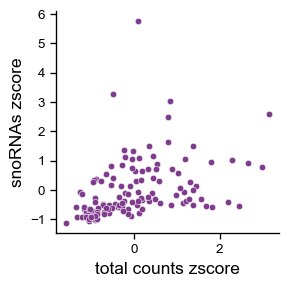

In [263]:
fig, ax = plt.subplots(1, figsize=(3, 3))
sns.scatterplot(x=total_counts, y=snornas)
sns.despine()
ax.set_xlabel("total counts zscore")
ax.set_ylabel("snoRNAs zscore")

We didn't remove those samples with higher SNO-RNA counts earlier, there's no reason we should do it now.

## Fetch the St Jude GTF reference

In [197]:
stjude_gtf = helper.read_gtf("https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_31/gencode.v31.annotation.gtf.gz")
stjude_gtf = helper.clean_and_subset_gtf(stjude_gtf, gene_ref)

In [274]:
stjude_gtf['gene_length'] = stjude_gtf['end'] - stjude_gtf['start']

In [264]:
stjude_gtf.head(2)

,chromosome,source,feature,start,end,score,strand,phase,attributes,gene_id,gene_type
gene_name,,,,,,,,,,,
OR4F5,chr1,HAVANA,gene,65419,71585,.,+,.,"{'gene_id': 'ENSG00000186092.6', 'gene_type': ...",ENSG00000186092,protein_coding
OR4F29,chr1,HAVANA,gene,450703,451697,.,-,.,"{'gene_id': 'ENSG00000284733.1', 'gene_type': ...",ENSG00000284733,protein_coding


## Normalize counts and TPMs

In [354]:
stjude_counts_norm = full_counts.copy()

row_sums = stjude_counts_norm.iloc[:, 1:].sum(axis=1).values.reshape(-1, 1)
stjude_counts_norm.iloc[:, 1:] = (stjude_counts_norm.iloc[:, 1:] / row_sums) * 1e6

In [355]:
stjude_gtf['gene_length'] = stjude_gtf['end'] - stjude_gtf['start']

In [358]:
tpms = full_counts[full_counts['gene'].isin(stjude_gtf.index)].copy().set_index('gene')

# rpkm
tpms = np.divide(tpms.T, np.array(stjude_gtf["gene_length"].loc[tpms.index]) / 1000)

# normalize to TPMs
tpms = np.divide(tpms.T, tpms.sum(axis=1)) * 1e6

In [359]:
test_tpms = tpms.iloc[0, :]
test_counts = stjude_counts_norm.iloc[0, 1:]

In [361]:
tpms.shape, test_counts.shape

((18583, 125), (125,))

In [347]:
log_tpms = np.log1p(tpms)

## Do some QC

I'd like to check as a baseline if the ewing's and neuroblastoma samples are significantly different.

In [287]:
norm_matrix = preprocessing.StandardScaler().fit_transform(log_tpms.T)
pca = decomposition.PCA(
    n_components=min(norm_matrix.shape[0] - 1, norm_matrix.shape[1]), random_state=0
)

# transform the data, then store the PC results
pca_transformed_data = pca.fit_transform(norm_matrix)

pca_tpm_df = pd.DataFrame(pca_transformed_data)
pca_tpm_df.columns = ["PC" + str(i) for i in range(1, len(pca_tpm_df.columns) + 1)]
pca_tpm_df.index = log_tpms.columns

In [288]:
pca_tpm_df["disease"] = included_samples_manifest.set_index("sample_name").loc[
    pca_tpm_df.index, "sj_diseases_general"
]

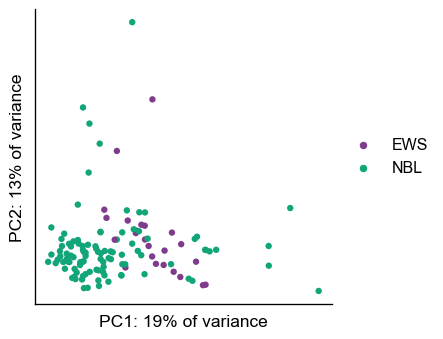

In [289]:
fig, ax = plt.subplots(1, figsize=(4, 4))

# plot data
sns.scatterplot(x="PC1", y="PC2", data=pca_tpm_df, hue="disease", ec=None)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="both", which="both", length=0)

pca_results = pca
ax.set_xlabel(
    "PC1: {:.0f}% of variance".format(pca_results.explained_variance_ratio_[0] * 100)
)
ax.set_ylabel(
    "PC2: {:.0f}% of variance".format(pca_results.explained_variance_ratio_[1] * 100)
)

sns.despine(bottom=False, left=False)
ax.legend(bbox_to_anchor=(1, 0.5))

I suppose that's not so bad? A little weird for sure.

## Compare TPMs between datasets

There's no way that this works.

In [290]:
gmkf_tpms_full = pd.read_csv(
    "data/merged_neuroblastoma_tpms_gmkf.tsv", sep="\t"
).rename(columns={"gene_symbol": "gene"})
gmkf_tpms_full.head(2)

,gene_id,ENSEMBL_ID,gene,PT_02SNWVRF,PT_0XAWD5CE,PT_10KTTTPD,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1MWZEHCT,PT_1NDSW1JX,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_1YAJEAMJ,PT_21PJ8R0Z,PT_22BQQFYM,PT_26E4RFYV,PT_2AZNEYG9,PT_2DX56CE0,PT_2FB9C15K,PT_2G290D0G,PT_2HCWZNTR,PT_2JZNQGTR,PT_2M970JK9,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_2YBKT6RW,PT_3VNMNFT6,PT_3WF5J3PZ,PT_3YW2V4JK,PT_49FZV0HC,PT_4A1B95TK,PT_4FTZAAC4,PT_4W8PD8TR,PT_4WVGKQRX,PT_4Y3P2N1P,PT_53M7K3JE,PT_56ZM694R,PT_581CW7RN,PT_58J0PB4V,PT_5CPS8GNT,PT_5E269C8Z,PT_5FCYBT0S,PT_5MA1YQ49,PT_5W51TAZS,PT_64B8K70Y,PT_66Y5KGME,PT_69AGBVQ5,PT_69EVASRX,PT_6DHGCDRP,PT_6HZH56MX,PT_6M0TPG4X,PT_6R3RJ6MY,PT_6TM0T48Z,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_7XV9SBKQ,PT_81RSHW1D,PT_82D2FJV2,PT_86NG4W76,PT_89D6BFGP,PT_8BYCCC0V,PT_8DFBAQVQ,PT_8HFHWZH9,PT_8RQQWAQR,PT_92RR9C8D,PT_9A9Q2YB3,PT_9DD8F0VD,PT_9GRB7EF0,PT_9K8VF0Z0,PT_9KB3ESTZ,PT_9NMNEV0Y,PT_9QQ37AWW,PT_9RJY3GWC,PT_9X3MV3GW,PT_A4VM4H5N,PT_A77B7F2F,PT_AGYJR7PZ,PT_APMAKP20,PT_AQS8CCAB,PT_ASH4P45D,PT_ASJZTDRF,PT_ATQMV6B3,PT_B0YZ0H85,PT_B39849MF,PT_B9CP3H35,PT_B9X3H54Y,PT_BZCXTAH9,PT_BZZY1BM4,PT_C32MGZSB,PT_C3YC0C9Q,PT_C6429DZZ,PT_CCC65GCE,PT_CV0FE3Z3,PT_D4SZQV48,PT_D508JGWE,PT_D5BYDHZ9,PT_D9XF79J4,PT_DCBZYQAX,PT_DP679T4D,PT_DS5XN67S,PT_E3R0MRXN,PT_E6CZS2KF,PT_E7PFZT6E,PT_ECTDZ6QS,PT_EKP4F49T,PT_ESKA5P5B,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FW0K9SXK,PT_FZ3XEWEK,PT_G3Q35987,PT_GGJ9E0VV,PT_GQBEY0JD,PT_GSWXPFPQ,PT_GV2XJJTP,PT_H2Q0BW73,PT_H3GBG09Q,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HC1QFR28,PT_HQ23GQ23,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_HZQ6TWR9,PT_J3X9NQ5F,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K5709E5B,PT_K579G3KQ,PT_K59VNJ70,PT_KBT22K39,PT_KBVX8B37,PT_KH0H9EZS,PT_KRHMQFFP,PT_KWEJJM22,PT_KWRFGRER,PT_KX5R6KSM,PT_KXWQXAR4,PT_M4ETZ912,PT_M6QAJFS8,PT_M8RHAK5K,PT_MG3HP8D9,PT_MK375DCF,PT_NK39AFPG,PT_NYMKWAZT,PT_NZ3F3J67,PT_P111JVHP,PT_P2M0Q2KS,PT_P7V330C5,PT_P9QJMTF8,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QCMS0C3W,PT_QF2A2F08,PT_QH23VVKW,PT_QW5Q0G84,PT_QZFYXPJK,PT_R07QYFJ0,PT_R94DDN50,PT_RG7MMHFF,PT_RJPEMEQV,PT_RMH6RJ1P,PT_RS3TBZV5,PT_RSPKGFXS,PT_RVTVP55V,PT_S4EJKTME,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V1HR5C5P,PT_V3BXBVVV,PT_V65ESGCE,PT_VA8GM98Z,PT_VVVS471N,PT_W6AVZF18,PT_WG51EA8V,PT_WH6RANZQ,PT_WSQ011Z1,PT_WWQGABFP,PT_WWRAC6EH,PT_X8N7GE8X,PT_XDPN4357,PT_XKZYFJZV,PT_XNBJNRXJ,PT_XNDPC9TT,PT_XPGEBQKA,PT_XPTE7785,PT_YGW6KQHQ,PT_YHWENHB0,PT_YJ8KZG27,PT_YMDFCE4V,PT_YPK89ADE,PT_YS31MFW0,PT_YYGH8EMR,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZS5D8MVF,PT_ZT2NW6WA,PT_ZW22K0YF
0,ENSG00000000003.14_TSPAN6,ENSG00000000003,TSPAN6,3.61,7.62,4.30,2.15,5.05,9.24,4.71,5.88,1.38,4.27,2.02,3.36,3.17,7.48,5.85,10.18,0.0,3.53,6.71,3.07,6.36,3.53,3.48,3.11,2.27,5.29,5.13,8.56,8.71,6.89,5.84,6.03,4.88,3.21,4.91,5.69,5.14,3.42,5.52,3.64,9.19,4.50,4.14,8.18,4.75,6.09,2.19,1.03,5.56,7.46,4.38,16.69,5.32,2.22,3.48,12.82,3.93,5.42,5.33,15.09,6.02,7.87,6.65,8.35,7.13,6.33,3.32,16.37,5.19,7.46,4.49,16.05,7.10,11.59,3.77,7.35,15.50,3.45,2.43,2.27,1.93,2.85,8.17,3.3,11.01,6.02,3.75,9.38,12.32,6.57,4.12,1.08,4.35,5.62,6.61,5.42,5.80,8.86,6.82,2.15,8.82,4.54,2.85,5.47,6.03,5.99,4.87,3.6,3.61,13.90,4.05,3.34,5.47,10.79,4.32,4.17,6.61,4.58,4.77,28.44,3.00,5.50,3.37,2.47,5.95,5.51,9.22,2.67,6.49,5.25,6.79,9.47,3.72,7.45,5.42,2.37,8.00,4.01,7.13,2.59,4.60,7.1,4.46,3.52,4.06,7.82,11.20,4.77,1.33,5.72,6.19,8.68,2.80,1.63,8.07,8.86,2.94,6.56,3.98,4.65,3.64,5.25,2.78,3.71,2.12,11.43,5.96,16.48,3.31,5.27,6.14,4.64,0.0,19.99,4.49,4.63,4.94,4.78,2.71,7.94,7.36,2.39,3.04,2.21,3.59,4.35,7.1,12.48,2.59,5.76,4.59,9.73,4.56,14.11,3.07,12.56,13.63,5.41,2.94,3.57,2.71,3.73,5.58,8.16,4.73,13.37,3.1,10.42,9.68
1,ENSG00000000005.5_TNMD,ENSG00000000005,TNMD,0.03,0.00,0.05,0.00,0.11,0.00,0.07,0.02,0.09,0.12,0.02,0.02,0.00,0.00,0.03,0.03,0.0,0.00,0.00,0.02,0.07,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.04,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.16,0.00,0.15,0.00,0.06,0.00,0.00,0.00,0.04,0.06,

Since this was done in RSEM, we have the TPMs for every gene. We will restrict to our gene subset from stjude

In [291]:
shared_genes = set(gmkf_tpms_full["gene"]) & set(tpms.index)
len(shared_genes)

18271

In [292]:
stjude_tpms = tpms.loc[shared_genes]
gmkf_tpms = gmkf_tpms_full.iloc[:, 2:].set_index("gene").loc[shared_genes]

# renormalize both
stjude_tpms = (stjude_tpms / stjude_tpms.sum()) * 1e6
gmkf_tpms = (gmkf_tpms / gmkf_tpms.sum()) * 1e6

And we combine

In [293]:
merged_tpms = (
    stjude_tpms.reset_index()
    .merge(gmkf_tpms.reset_index(), on="gene")
    .sort_values(by="gene")
    .set_index("gene")
)
merged_log_tpms = np.log1p(merged_tpms)

In [294]:
norm_matrix = preprocessing.StandardScaler().fit_transform(merged_log_tpms.T)
pca = decomposition.PCA(
    n_components=min(norm_matrix.shape[0] - 1, norm_matrix.shape[1]), random_state=0
)

# transform the data, then store the PC results
pca_transformed_data = pca.fit_transform(norm_matrix)

pca_tpm_df = pd.DataFrame(pca_transformed_data)
pca_tpm_df.columns = ["PC" + str(i) for i in range(1, len(pca_tpm_df.columns) + 1)]
pca_tpm_df.index = merged_log_tpms.columns

In [295]:
pca_tpm_df["source"] = [
    "stjude" if s in stjude_tpms.columns else "gmkf" for s in pca_tpm_df.index
]

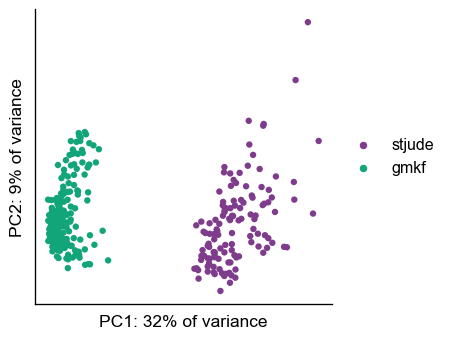

In [296]:
fig, ax = plt.subplots(1, figsize=(4, 4))

# plot data
sns.scatterplot(x="PC1", y="PC2", data=pca_tpm_df, hue="source", ec=None)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="both", which="both", length=0)

pca_results = pca
ax.set_xlabel(
    "PC1: {:.0f}% of variance".format(pca_results.explained_variance_ratio_[0] * 100)
)
ax.set_ylabel(
    "PC2: {:.0f}% of variance".format(pca_results.explained_variance_ratio_[1] * 100)
)

sns.despine(bottom=False, left=False)
ax.legend(bbox_to_anchor=(1, 0.5))

Note that this includes ewing's sarcoma samples too, so it's clear that we have a massive batch effect.

## Export St Jude's

Again we export. We have to handle the neuroblastoma and ewing's sarcoma samples differently.

In [362]:
# we need to replace the sample names from the stjude dataset with subject names
# to match our dataset.
replace_dict = dict(
    zip(
        included_samples_manifest["sample_name"],
        included_samples_manifest["subject_name"],
    )
)

In [363]:
stjude_counts_norm_export = stjude_counts_norm[stjude_counts_norm['gene'].isin(stjude_gtf.index)].copy()

# drop genes that aren't expressed
stjude_counts_norm_export = stjude_counts_norm_export.dropna().set_index('gene')
stjude_counts_norm_export.columns = [replace_dict.get(s, s) for s in stjude_counts_norm_export.columns]

In [367]:
stjude_counts_protein_coding = (
        full_counts[full_counts["gene"].isin(disease_counts.index)]
    ).set_index('gene')

stjude_counts_protein_coding.columns = [replace_dict.get(s, s) for s in stjude_counts_protein_coding.columns]

In [368]:
for disease in ['neuroblastoma', 'ewing']:
    
    # get the disease data
    dz_short = 'NBL' if disease == "neuroblastoma" else 'EWS'
    disease_counts = stjude_counts_norm_export.copy()
    disease_samples = set(stjude_counts_norm_export.columns) & set(manifest.query(f'sj_diseases_general == "{dz_short}"')['subject_name'])
    disease_counts = disease_counts[disease_samples]

    # again, filter by minimum counts
    included_samples = metadata[
        (metadata["entity:sample_id"].isin(list(disease_counts.columns)))
        & (metadata[f"{disease}_case"] == True)
    ]["entity:sample_id"].tolist()

    # keep genes that have at least 10 counts in at least 5 samples (following DESEQ's recommendations)
    expressed = (stjude_counts_protein_coding[included_samples] >= 10).sum(axis = 1) >= 5

    # and fewer than 20% of samples can have zero expression
    min_greater_than_zero = (stjude_counts_protein_coding[included_samples] == 0).mean(axis = 1) <= 0.20

    kept_rows = expressed & min_greater_than_zero

    kept_genes = stjude_counts_protein_coding.index[kept_rows]
    
    disease_counts_export = disease_counts.loc[kept_genes]
    
    disease_counts_export.to_csv(f'data/stjude_{disease}_filtered_normalized_counts.csv')